# **Library and Module Imports**


In [122]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Flatten,LSTM, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS
from collections import Counter
from wordcloud import WordCloud









In [59]:

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download("vader_lexicon")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matewosberhe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/matewosberhe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/matewosberhe/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# **1. Data Loading and Initial Preprocessing**

In [60]:

df = pd.read_csv('drugs.csv')


In [61]:
# Drop unnecessary column
df = df.drop(columns=["Unnamed: 0"], errors='ignore')

In [62]:
# Handle missing values
df = df.dropna(subset=['review', 'date', 'rating', 'condition'])
df['date'] = pd.to_datetime(df['date'], errors='coerce')


In [63]:
df = df.drop_duplicates()  # Ensure no duplicate rows

# **2.Text Processing**

In [65]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Preprocess the input text:
    - Convert to lowercase
    - Remove special characters and numbers
    - Handle negation phrases
    - Tokenize, remove stopwords, and lemmatize
    """

    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)

    # Handle negation phrases
    negation_pattern = r'\b(?:not|no|never|cannot|don\'t|doesn\'t|didn\'t|isn\'t|aren\'t|won\'t|can\'t|shouldn\'t)\s+(\w+)'
    text = re.sub(negation_pattern, r'not_\1', text)

    # Tokenize and process
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_review'] = df['review'].apply(preprocess_text)



# **3.Feature Engineering**

In [66]:
# Add review length (character count) and word count for EDA
df['review_length'] = df['cleaned_review'].apply(len)
df['word_count'] = df['cleaned_review'].apply(lambda x: len(x.split()))

# Remove rows with empty or very short reviews after preprocessing
df = df[df['review_length'] > 1]


In [67]:
print("\nMissing Values by Column:")
print(df.isnull().sum())


Missing Values by Column:
drugName          0
condition         0
review            0
rating            0
date              0
usefulCount       0
cleaned_review    0
review_length     0
word_count        0
dtype: int64


# **4.Explatory Data Analysis**

**4.1 Plot histogram of word count**

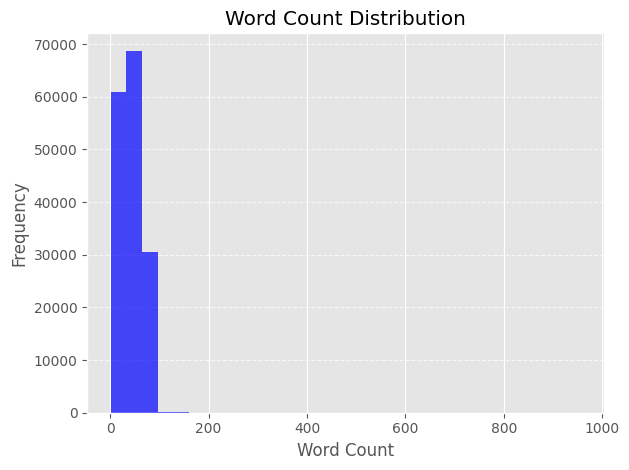

In [69]:
df['word_count'].hist(bins=30, color='blue', alpha=0.7)
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



**4.2 Plot histogram of review lengths**

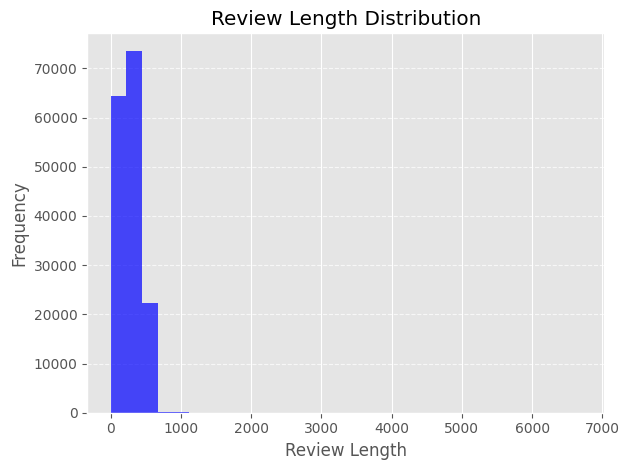

In [70]:

df['review_length'].hist(bins=30, color='blue', alpha=0.7)
plt.title('Review Length Distribution')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**4.3 Plot histogram of Distribution of Drug Rating**

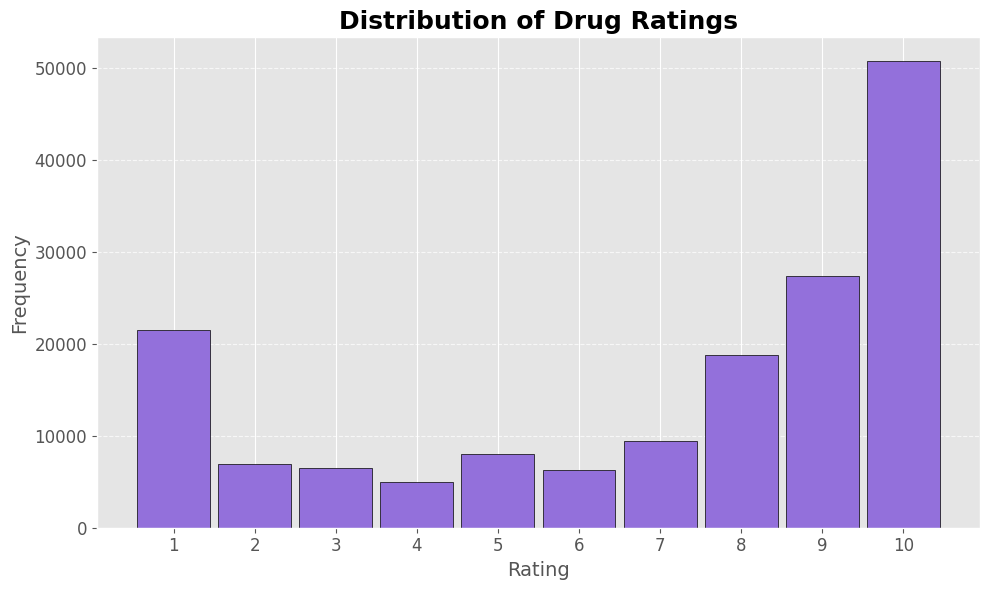

In [71]:
plt.style.use('ggplot')

plt.figure(figsize=(10, 6))
plt.hist(
    df['rating'],
    bins=range(1, 12),
    color='mediumpurple',
    edgecolor='black',
    align='left',
    rwidth=0.9
)
plt.title('Distribution of Drug Ratings', fontsize=18, weight='bold')
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(range(1, 11), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


**4.4 Bar chart of Top 10 most common condition**

/var/folders/7k/v_jnhg6d6tbfgjf3wx5_8lfr0000gn/T/ipykernel_1536/1965781061.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues')


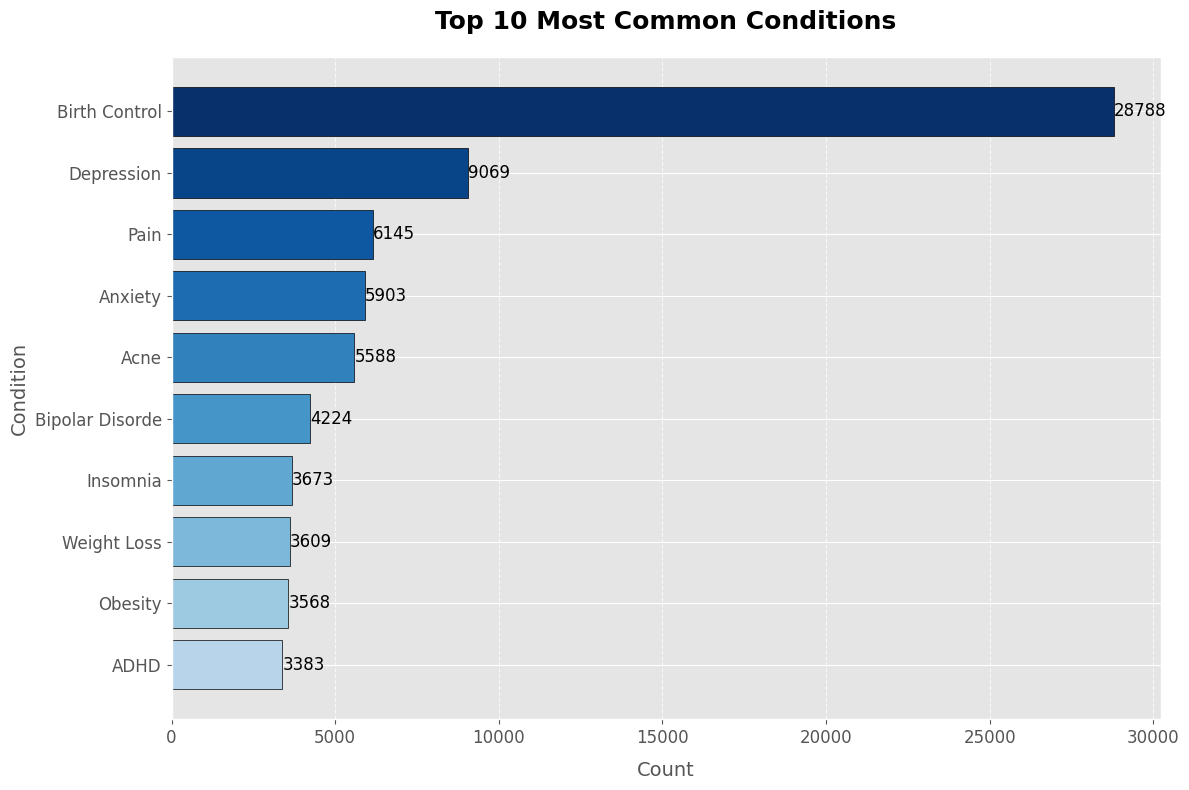

In [72]:
most_common_conditions = df['condition'].value_counts().head(10)
values = most_common_conditions.values
cmap = cm.get_cmap('Blues')
colors = cmap(np.linspace(1, 0.3, len(values)))

plt.figure(figsize=(12, 8))
bars = plt.barh(
    most_common_conditions.index,
    most_common_conditions.values,
    color=colors,
    edgecolor='black'
)
plt.title('Top 10 Most Common Conditions', fontsize=18, weight='bold', loc='center', pad=20)
plt.xlabel('Count', fontsize=14, labelpad=10)
plt.ylabel('Condition', fontsize=14)

for index, value in enumerate(most_common_conditions):
    plt.text(value + 5, index, str(value), fontsize=12, va='center', color='black')

plt.gca().invert_yaxis()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()


**4.5 Bar Chart of Top 10 most common drugs**

/var/folders/7k/v_jnhg6d6tbfgjf3wx5_8lfr0000gn/T/ipykernel_1536/175635430.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds')


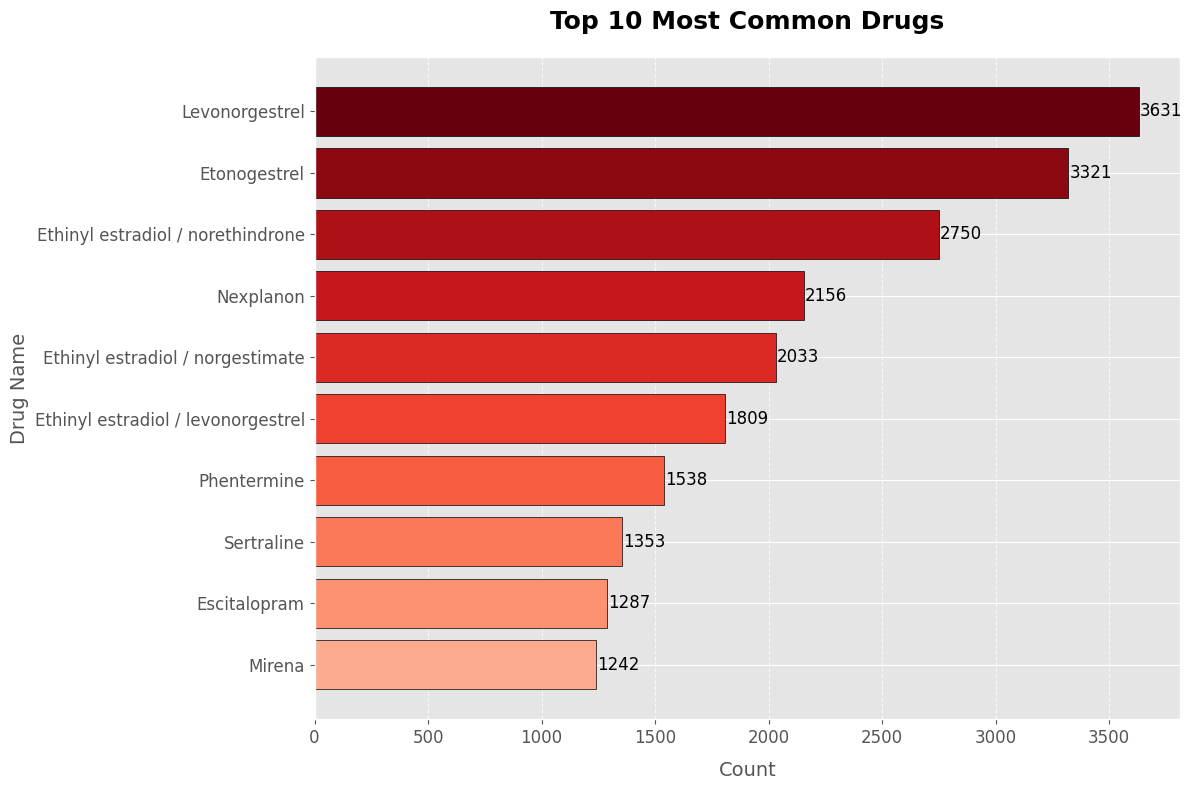

In [74]:
most_common_drugs = df['drugName'].value_counts().head(10)
values = most_common_drugs.values
cmap = cm.get_cmap('Reds')
colors = cmap(np.linspace(1, 0.3, len(values)))

plt.figure(figsize=(12, 8))
bars = plt.barh(
    most_common_drugs.index,
    most_common_drugs.values,
    color=colors,
    edgecolor='black'
)

plt.title('Top 10 Most Common Drugs', fontsize=18, weight='bold', loc='center', pad=20)
plt.xlabel('Count', fontsize=14, labelpad=10)
plt.ylabel('Drug Name', fontsize=14)

for index, value in enumerate(most_common_drugs):
    plt.text(value + 5, index, str(value), fontsize=12, va='center', color='black')

plt.gca().invert_yaxis()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**4.6 Average rating over time for top 5 drugs**

<Figure size 1400x800 with 0 Axes>

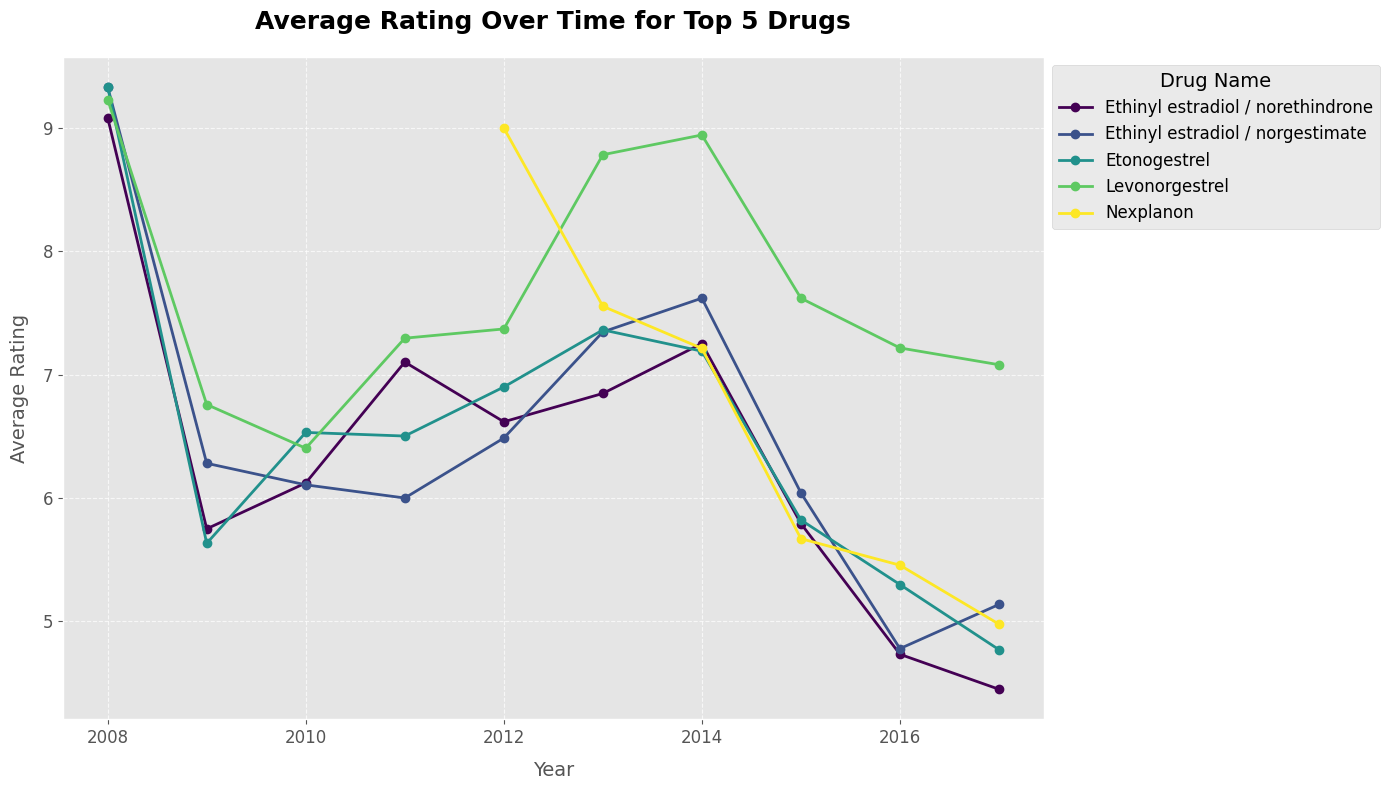

In [75]:

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# Identify the top 5 most frequent drugs
top_drugs = df['drugName'].value_counts().head(5).index

# Filter the data for only the top 5 drugs
filtered_data = df[df['drugName'].isin(top_drugs)]
avg_rating_per_year_drug = filtered_data.groupby(['year', 'drugName'])['rating'].mean().unstack()

plt.figure(figsize=(14, 8))
ax = avg_rating_per_year_drug.plot(kind='line', marker='o', linewidth=2, figsize=(14, 8), colormap='viridis')

plt.title('Average Rating Over Time for Top 5 Drugs', fontsize=18, weight='bold', loc='center', pad=20)
plt.xlabel('Year', fontsize=14, labelpad=10)
plt.ylabel('Average Rating', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(title='Drug Name', fontsize=12, title_fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

plt.grid(visible=True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


**4.7 Correlation Heatmap of review length vs Rating**

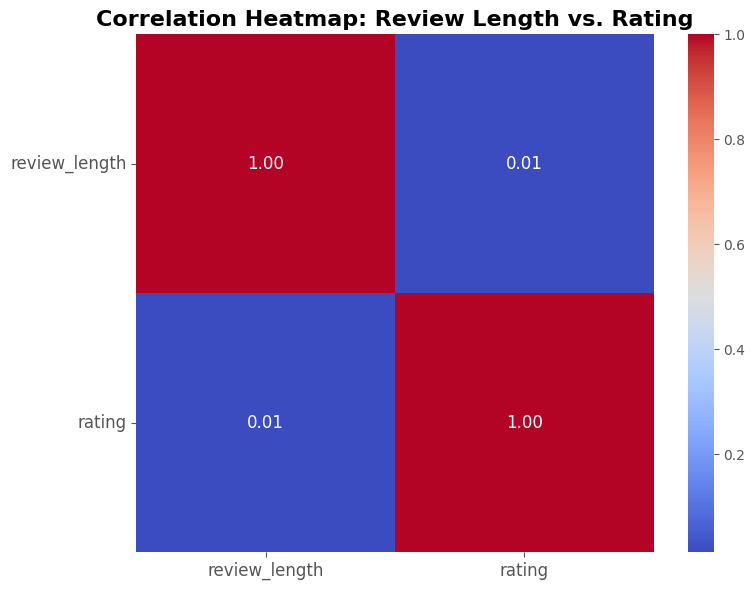

In [76]:
correlation_matrix = df[['review_length', 'rating']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    cbar=True,
    square=True,
    annot_kws={'fontsize': 12}
)

plt.title('Correlation Heatmap: Review Length vs. Rating', fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()


**4.8 Correlation Heatmap of review length vs Rating**

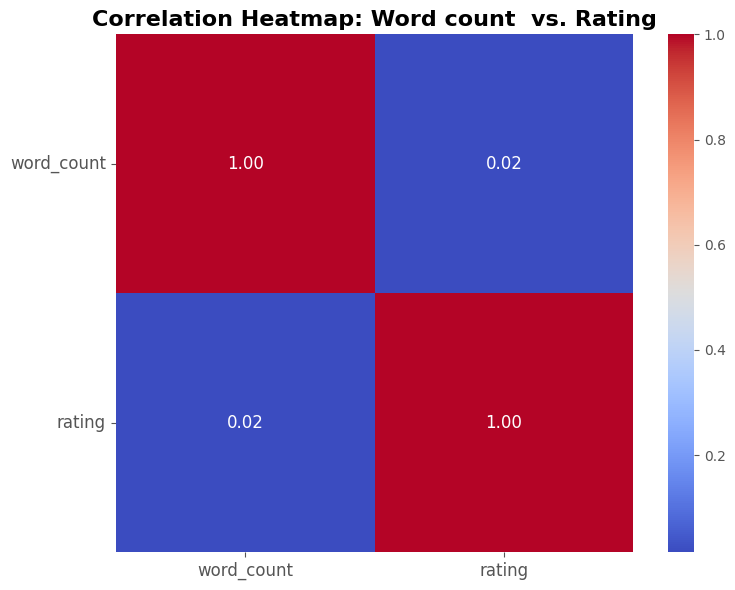

In [77]:
correlation_matrix = df[['word_count', 'rating']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    cbar=True,
    square=True,
    annot_kws={'fontsize': 12}
)

plt.title('Correlation Heatmap: Word count  vs. Rating', fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

**4.9 Word cloud for reviews**

Generating Word Cloud for Positive Reviews...



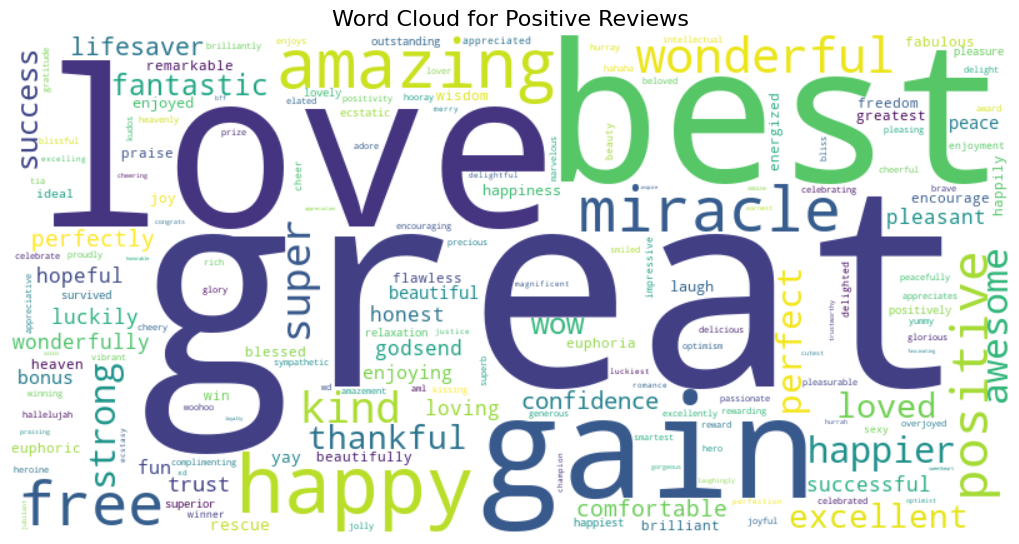


Generating Word Cloud for Negative Reviews...



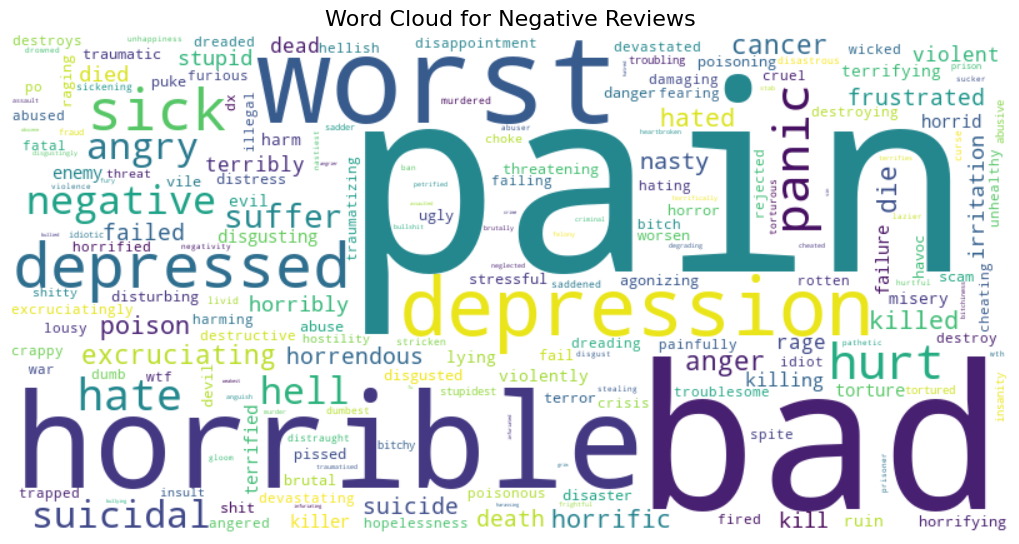

In [78]:
# a. Aggregate positive and negative reviews
positive_reviews = " ".join(df[df['rating'] > 7]['cleaned_review'])
negative_reviews = " ".join(df[df['rating'] < 4]['cleaned_review'])

sia = SentimentIntensityAnalyzer()
def extract_sentiment_words_with_frequencies(text, sentiment="positive", threshold=0.5):

    words = text.split()
    sentiment_words = []

    for word in words:
        score = sia.polarity_scores(word)["compound"]
        if sentiment == "positive" and score > threshold:
            sentiment_words.append(word)
        elif sentiment == "negative" and score < -threshold:
            sentiment_words.append(word)

    return Counter(sentiment_words)

positive_word_frequencies = extract_sentiment_words_with_frequencies(positive_reviews, sentiment="positive", threshold=0.5)
negative_word_frequencies = extract_sentiment_words_with_frequencies(negative_reviews, sentiment="negative", threshold=0.5)

# Generate word cloud from word frequencies
def generate_word_cloud_from_frequencies(frequencies, title, figsize=(10, 6)):

    wordcloud = WordCloud(
        background_color='white',
        colormap='viridis',
        width=800,
        height=400
    ).generate_from_frequencies(frequencies)


    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout(pad=0)
    plt.show()

print("Generating Word Cloud for Positive Reviews...\n")
generate_word_cloud_from_frequencies(
    positive_word_frequencies, title="Word Cloud for Positive Reviews"
)

print("\nGenerating Word Cloud for Negative Reviews...\n")
generate_word_cloud_from_frequencies(
    negative_word_frequencies, title="Word Cloud for Negative Reviews"
)

**4.10 Box plot of Distribution of Useful count**

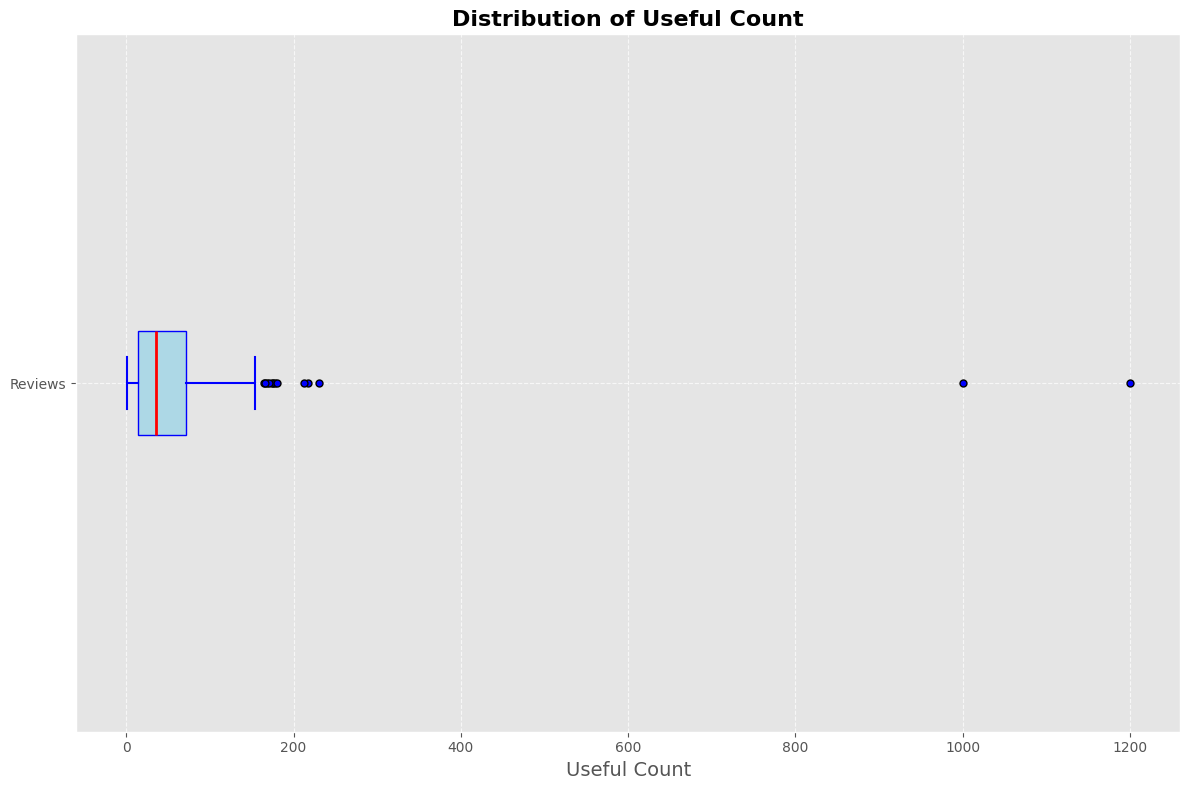

In [79]:
np.random.seed(42)
data = np.append(np.random.exponential(scale=50, size=300), [1000, 1200])


plt.figure(figsize=(12, 8))
plt.boxplot(data, vert=False, patch_artist=True,
            boxprops=dict(facecolor="lightblue", color="blue"),
            medianprops=dict(color="red", linewidth=2),
            whiskerprops=dict(color="blue", linewidth=1.5),
            capprops=dict(color="blue", linewidth=1.5),
            flierprops=dict(markerfacecolor="blue", marker="o", markersize=5))


plt.yticks([1], ['Reviews'])

# Adding titles and labels for clarity
plt.title("Distribution of Useful Count", fontsize=16, fontweight='bold')
plt.xlabel("Useful Count", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


**4.11 Bar graph of top 10 most common n-grams**

In [80]:
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english', max_features=200)


/var/folders/7k/v_jnhg6d6tbfgjf3wx5_8lfr0000gn/T/ipykernel_1536/3440523579.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bigram_df.head(10), y='ngram', x='count', palette='viridis')


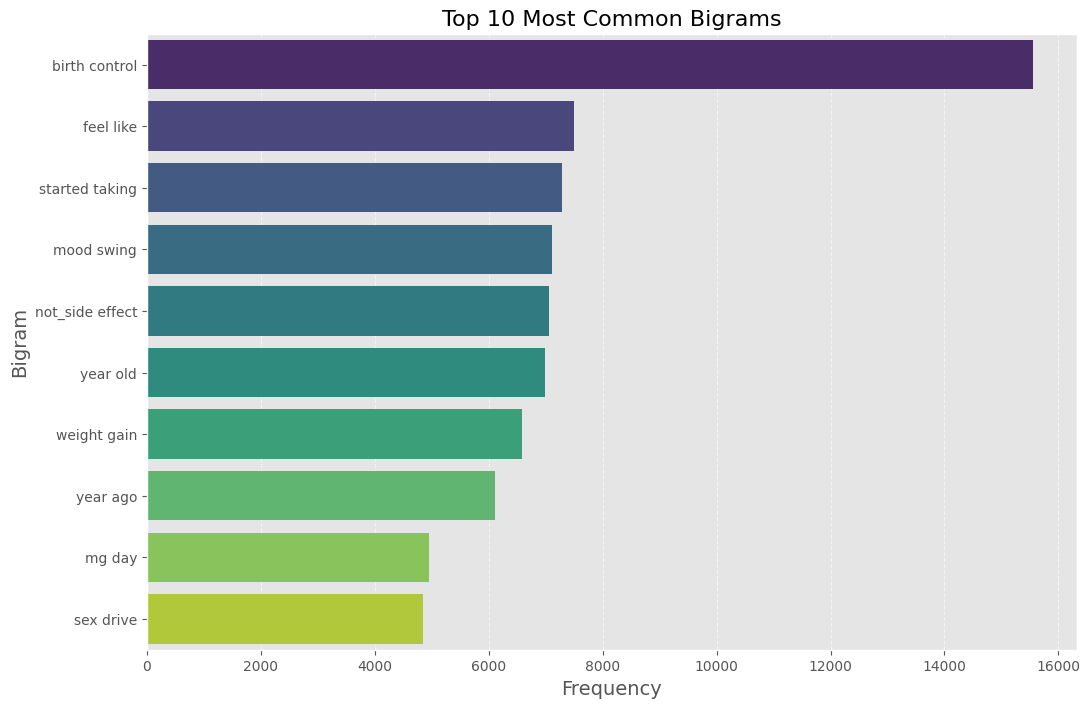

In [81]:
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=50)
X_bigrams = bigram_vectorizer.fit_transform(df['cleaned_review'])
bigram_counts = X_bigrams.sum(axis=0).A1
bigram_features = bigram_vectorizer.get_feature_names_out()
bigram_df = pd.DataFrame({'ngram': bigram_features, 'count': bigram_counts}).sort_values(by='count', ascending=False)


# Visualize Top 10 Bigrams
plt.figure(figsize=(12, 8))
sns.barplot(data=bigram_df.head(10), y='ngram', x='count', palette='viridis')
plt.title('Top 10 Most Common Bigrams', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Bigram', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()




/var/folders/7k/v_jnhg6d6tbfgjf3wx5_8lfr0000gn/T/ipykernel_1536/1827714139.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=trigram_df.head(10), y='ngram', x='count', palette='magma')


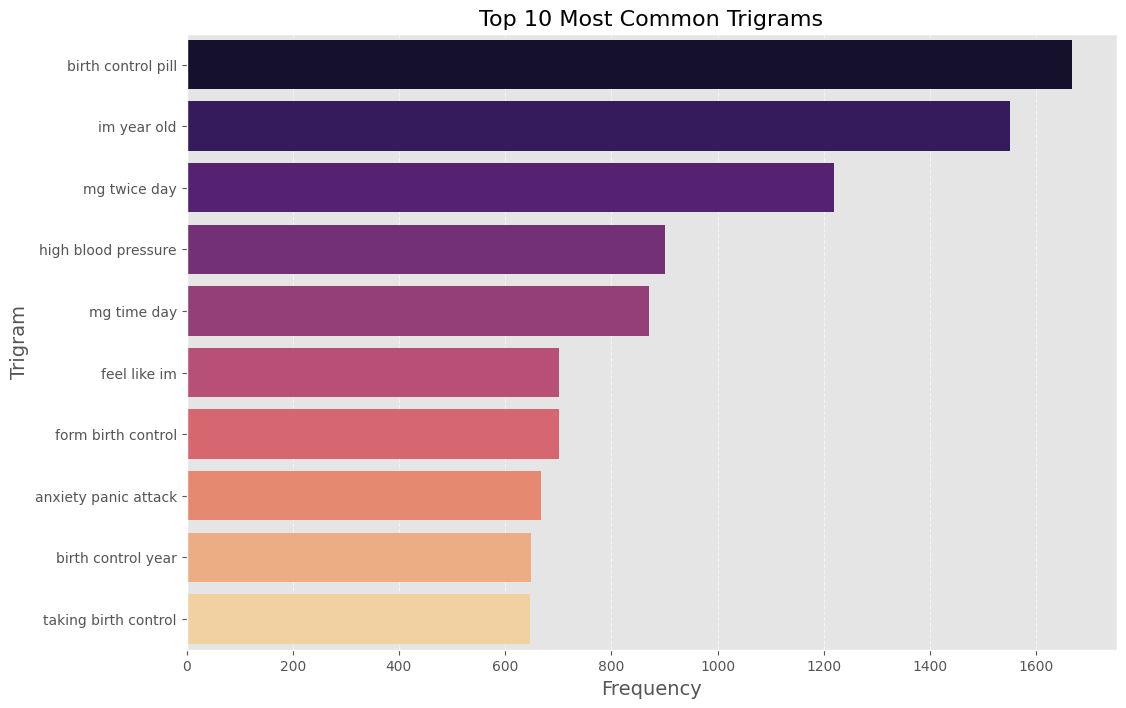

In [82]:
# Visualize Top 10 Trigrams

trigram_vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english', max_features=50)
X_trigrams = trigram_vectorizer.fit_transform(df['cleaned_review'])
trigram_counts = X_trigrams.sum(axis=0).A1
trigram_features = trigram_vectorizer.get_feature_names_out()
trigram_df = pd.DataFrame({'ngram': trigram_features, 'count': trigram_counts}).sort_values(by='count', ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(data=trigram_df.head(10), y='ngram', x='count', palette='magma')
plt.title('Top 10 Most Common Trigrams', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Trigram', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# **Models**

### **Naive baise Model(MultinomialNB)**

In [27]:
X = df[['cleaned_review', 'drugName', 'condition']]
y = df['rating']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', MultinomialNB())
])

# Fit the model on the training data
pipeline.fit(X_train['cleaned_review'], y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test['cleaned_review'])

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
#print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.4107671685526357


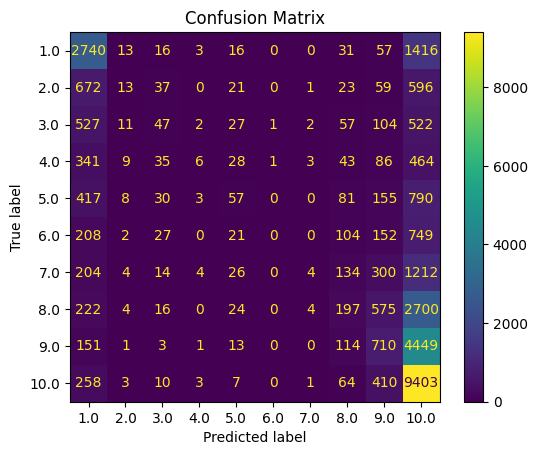

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = pipeline.predict(X_test['cleaned_review'])

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap='viridis')

# Show the plot
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for TfidfVectorizer and Naive Bayes
param_grid = {
    'vectorizer__max_features': [5000, 10000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__alpha': [0.1, 1.0, 1.5]
}

# Create GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit grid search on the training data
grid_search.fit(X_train['cleaned_review'], y_train)

# Print the best parameters and the best cross-validated score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


Best Parameters: {'classifier__alpha': 0.1, 'vectorizer__max_features': 10000, 'vectorizer__ngram_range': (1, 2)}
Best Cross-Validation Score: 0.4274658927329673


In [ ]:
import pickle

# Save the trained model to a file
with open('naive_bayes_model.pkl', 'wb') as model_file:
    pickle.dump(pipeline, model_file)

# Load the model from the file
with open('naive_bayes_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)


In [ ]:
# Function to make predictions and show related details based on a review
def predict_and_show_details(review_input):
    # Predict the rating for the input review
    predicted_rating = loaded_model.predict([review_input])[0]

    # Find the matching review in the original DataFrame
    matching_row = df[df['cleaned_review'] == review_input]

    if not matching_row.empty:
        actual_rating = matching_row['rating'].values[0]
        drug_name = matching_row['drugName'].values[0]
        condition = matching_row['condition'].values[0]

        # Display the review details and predictions
        print(f"Review: '{review_input}'")
        print(f"Drug Name: '{drug_name}'")
        print(f"Condition: '{condition}'")
        print(f"Actual Rating: {actual_rating}")
        print(f"Predicted Rating: {predicted_rating}")
        print("-" * 50)
    else:
        print(f"No matching review found for: '{review_input}'")
        print("-" * 50)

# List of test reviews
test_reviews = ['limited improvement month developed bad rash md refused continue medication']

# Make predictions and show details for each review
for review in test_reviews:
    predict_and_show_details(review)


Review: 'limited improvement month developed bad rash md refused continue medication'
Drug Name: 'Etanercept'
Condition: 'Rheumatoid Arthritis'
Actual Rating: 4.0
Predicted Rating: 1.0
--------------------------------------------------


# **Embedding-Based Retrieval**

In [ ]:
df['cleaned_review'] = df['cleaned_review'].fillna("").astype(str)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_review'])

# Step 2: Sentence-BERT Embeddings
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
sbert_embeddings = sbert_model.encode(df['cleaned_review'].tolist(), convert_to_tensor=True)
# print("SBERT embeddings shape:", sbert_embeddings.shape)


In [96]:
def retrieve_relevant_documents(query, top_n=5):
    """
    Retrieve relevant documents based on the query using Sentence-BERT.
    """
    query_embedding = sbert_model.encode(query, convert_to_tensor=True)
    
    # Move similarities tensor to CPU for compatibility with NumPy
    similarities = util.pytorch_cos_sim(query_embedding, sbert_embeddings).squeeze(0).cpu().numpy()
    
    # Find top-n most similar documents
    similar_indices = similarities.argsort()[-top_n:][::-1]

    if len(similar_indices) == 0 or similarities[similar_indices[0]] < 0.1:  # Low similarity threshold
        return None, "The question is out of context or unrelated to the dataset."

    return df.iloc[similar_indices][['drugName', 'condition', 'cleaned_review', 'rating']], None


# **Neural Network for Rating Prediction**

In [98]:
# Neural Network for Rating Prediction
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_review'])
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])
max_sequence_length = 100
X = pad_sequences(sequences, maxlen=max_sequence_length)
y = df['rating'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the Neural Network
model = Sequential([
    Embedding(input_dim=5000, output_dim=128),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='linear')  # Linear activation for regression
])
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)


Epoch 1/5
4010/4010 ━━━━━━━━━━━━━━━━━━━━ 201s 50ms/step - loss: 11.0696 - mae: 2.6827 - mse: 11.0696 - val_loss: 5.3596 - val_mae: 1.8193 - val_mse: 5.3596
Epoch 2/5
4010/4010 ━━━━━━━━━━━━━━━━━━━━ 195s 49ms/step - loss: 5.7026 - mae: 1.8662 - mse: 5.7026 - val_loss: 4.3982 - val_mae: 1.5361 - val_mse: 4.3982
Epoch 3/5
4010/4010 ━━━━━━━━━━━━━━━━━━━━ 195s 49ms/step - loss: 4.5522 - mae: 1.6417 - mse: 4.5522 - val_loss: 4.1786 - val_mae: 1.4845 - val_mse: 4.1786
Epoch 4/5
4010/4010 ━━━━━━━━━━━━━━━━━━━━ 195s 49ms/step - loss: 3.8224 - mae: 1.4866 - mse: 3.8224 - val_loss: 4.1128 - val_mae: 1.4911 - val_mse: 4.1128
Epoch 5/5
4010/4010 ━━━━━━━━━━━━━━━━━━━━ 196s 49ms/step - loss: 3.2891 - mae: 1.3670 - mse: 3.2891 - val_loss: 3.9758 - val_mae: 1.3988 - val_mse: 3.9758


In [99]:
#Evaluate the Model
print("\nModel Evaluation:")
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Absolute Error (MAE): {results[1]}")
print(f"Mean Squared Error (MSE): {results[2]}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(results[2])}")

# Additional Evaluation Metrics
y_pred = model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")




Model Evaluation:
Mean Absolute Error (MAE): 1.3987855911254883
Mean Squared Error (MSE): 3.975797414779663
Root Mean Squared Error (RMSE): 1.9939401733200681
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step
R^2 Score: 0.6296439514356409


In [104]:
def chatbot(input_text):
    """
    Chatbot logic to process user input and provide responses for questions or review predictions.
    """
    try:
        if not input_text.strip():
            return "Input cannot be empty. Please type a question or a drug review."

        if input_text.endswith("?"):  # Handle questions
            # Retrieve relevant documents
            relevant_docs, retrieval_error = retrieve_relevant_documents(input_text, top_n=5)
            if retrieval_error or relevant_docs is None or relevant_docs.empty:
                return "No relevant documents found or an error occurred."

            # Ensure the 'cleaned_review' and 'rating' columns exist
            if 'cleaned_review' not in relevant_docs.columns or 'rating' not in relevant_docs.columns:
                return "Error: Necessary columns are missing in the retrieved documents."

            # Ensure the 'rating' column is numeric
            relevant_docs['rating'] = pd.to_numeric(relevant_docs['rating'], errors='coerce')

            # Prepare context
            context, context_error = prepare_context(relevant_docs)
            if context_error:
                return context_error

            # Use QA model to get an answer
            answer = semantic_question_answering(input_text, context)
            avg_rating = relevant_docs['rating'].mean()
            drug_names = relevant_docs['drugName'].unique() if 'drugName' in relevant_docs.columns else []

            # Extract and deduplicate positive and negative reviews
            positive_reviews = relevant_docs[relevant_docs['rating'] >= 7]['cleaned_review'].dropna().tolist()
            negative_reviews = relevant_docs[relevant_docs['rating'] < 7]['cleaned_review'].dropna().tolist()

            # Deduplicate reviews
            positive_reviews = list(set(positive_reviews))
            negative_reviews = list(set(negative_reviews))

            # Return detailed question response
            return {
                "Answer from Reviews": answer,
                "Average Rating": avg_rating,
                "Drugs Mentioned": drug_names.tolist(),
                "Positive Reviews": positive_reviews if positive_reviews else "No positive reviews found.",
                "Negative Reviews": negative_reviews if negative_reviews else "No negative reviews found."
            }

        else:  # Handle review predictions
            processed_input = preprocess_text(input_text)
            input_sequence = tokenizer.texts_to_sequences([processed_input])
            input_padded = pad_sequences(input_sequence, maxlen=max_sequence_length)
            predicted_rating = model.predict(input_padded)[0][0]
            return f"Predicted Rating: {predicted_rating:.2f}"

    except Exception as e:
        return f"An error occurred: {str(e)}"


In [120]:
if __name__ == "__main__":
    print("Welcome to the Drug Review Chatbot!")
    print("Type your question (e.g., 'What are reviews for drugs treating anxiety?') or submit a drug review.")
    print("Type 'exit' to quit.")

    while True:
        user_input = input("\nYour Input: ").strip()
        if not user_input:
            print("Input cannot be empty. Please type a question or a drug review.")
            continue

        if user_input.lower() == 'exit':
            print("Thank you for using the chatbot. Goodbye!")
            break

        response = chatbot(user_input)

        if isinstance(response, dict):  # Handle detailed question response
            print("\n--- Question Response ---")
            print(f"Answer from Reviews: {response['Answer from Reviews']}")
            print(f"Average Rating: {response['Average Rating']:.2f}")
            print(f"Drugs Mentioned: {', '.join(response['Drugs Mentioned'])}")

            # Handle Positive Reviews
            print("\nPositive Reviews:")
            positive_reviews = response.get('Positive Reviews', "No positive reviews found.")
            if isinstance(positive_reviews, str):
                print(positive_reviews)
            else:
                for review in positive_reviews:
                    print(f"- {review}")

            # Handle Negative Reviews
            print("\nNegative Reviews:")
            negative_reviews = response.get('Negative Reviews', "No negative reviews found.")
            if isinstance(negative_reviews, str):
                print(negative_reviews)
            else:
                for review in negative_reviews:
                    print(f"- {review}")

        else:  # Handle review prediction response
            print("\n--- Review Prediction ---")
            print(response)



Welcome to the Drug Review Chatbot!
Type your question (e.g., 'What are reviews for drugs treating anxiety?') or submit a drug review.
Type 'exit' to quit.

--- Question Response ---
Answer from Reviews: medicine ive ever used helped decrease anxiety helped anxiety medicine
Average Rating: 10.00
Drugs Mentioned: Clonazepam, Klonopin, Valium, Diazepam

Positive Reviews:
- helped anxiety medicine
- medicine ive ever used helped decrease anxiety

Negative Reviews:
No negative reviews found.

--- Question Response ---
Answer from Reviews: typically people go online leave bad review hand great experience birth control
Average Rating: 6.80
Drugs Mentioned: Drospirenone / ethinyl estradiol, Desogestrel / ethinyl estradiol, NuvaRing, Ethinyl estradiol / norethindrone, Blisovi Fe 1.5 / 30

Positive Reviews:
- best birth control ever not_had problem medication
- hope people arent deterred review site typically people go online leave bad review hand great experience birth control thus far month n

In [110]:
df.head()

,drugName,condition,review,rating,date,usefulCount,cleaned_review,review_length,word_count,year
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,2012-05-20,27,not_side effect take combination bystolic mg f...,53,8,2012
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,2010-04-27,192,son halfway fourth week intuniv became concern...,424,65,2010
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,2009-12-14,17,used take another oral contraceptive pill cycl...,464,71,2009
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,2015-11-03,10,first time using form birth control im glad we...,241,40,2015
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,2016-11-27,37,suboxone completely turned life around feel he...,447,62,2016


In [117]:
print(df['cleaned_review'][0])


not_side effect take combination bystolic mg fish oil
